In [1]:
import sys, os
import numpy as np

from model_fitting import initialize_fitting 
from utils import numpy_utils
from analyze_features import load_feature_stats

import matplotlib.pyplot as plt
from matplotlib import cm
import cmocean

from plotting import load_fits, plot_utils

In [2]:
# Load everything

models = initialize_fitting.get_prf_models(which_grid=5)
n_prfs = len(models)
feature_type='pyramid_texture_ll'

subject='all'

mean, var, covar = \
        load_feature_stats.load_feature_stats(feature_type, subject='all')
corr, discrim, nsamp, names, signed_names = \
        load_feature_stats.load_feature_semantic_corrs(feature_type, subject='all')
partial_corr, partial_nsamp, partial_names, partial_signed_names = \
        load_feature_stats.load_feature_semantic_partial_corrs(feature_type, subject='all')

n_total_discrim_types = corr.shape[2]
n_features = corr.shape[0]
n_partial_discrim_types = partial_corr.shape[2]
axes_to_do_partial = [0,2,3]

In [3]:
# Gather information about the feature channels
import pandas as pd
from utils import default_paths
fn2save = os.path.join(default_paths.pyramid_texture_feat_path,'pyr_pars.csv')
pyr_df = pd.read_csv(fn2save, index_col=0)

n_ori = 4; n_sf=4;

ori_unique = np.array([0,45,90,135])
sf_unique = np.flip(np.array(pyr_df['approx center (cyc/deg)']))

pyr_df


,lowpass cutoff (cyc/pix),highpass cutoff (cyc/pix),approx center (cyc/pix),lowpass cutoff (cyc/deg),highpass cutoff (cyc/deg),approx center (cyc/deg)
0,0.125000,0.5000,0.25000,3.571429,14.285714,7.142857
1,0.062500,0.2500,0.12500,1.785714,7.142857,3.571429
2,0.031250,0.1250,0.06250,0.892857,3.571429,1.785714
3,0.015625,0.0625,0.03125,0.446429,1.785714,0.892857


In [4]:
# initialize the pyramid texture feature extractor to get diff feature set labels
from feature_extraction import texture_statistics_pyramid, fwrf_features
which_prf_grid=5
feature_types_all = texture_statistics_pyramid.feature_types_all
feature_type_dims_all = texture_statistics_pyramid.feature_type_dims_all
feat_loader = fwrf_features.fwrf_feature_loader(subject=1,\
                which_prf_grid=which_prf_grid, \
                feature_type='pyramid_texture',\
                n_ori=4, n_sf=4,\
                include_ll=True, include_hl=False,\
                use_pca_feats_hl = True,\
                group_all_hl_feats=False, prf_batch_size=1)     
n_feature_types = len(feature_types_all)



In [5]:
feature_types_all[1]

'mean_magnitudes'

In [6]:
# just focus on the mean_magnitudes features here

feat_inds_use = feat_loader.feature_column_labels==1

mean_reshaped = np.reshape(mean[feat_inds_use, :], [n_ori, n_sf, n_prfs], order = 'F')
var_reshaped = np.reshape(var[feat_inds_use, :], [n_ori, n_sf, n_prfs], order = 'F')
 
corr_reshaped = np.reshape(corr[feat_inds_use, :,:], \
                                  [n_ori, n_sf, n_prfs, n_total_discrim_types], order='F')
discrim_reshaped = np.reshape(discrim[feat_inds_use, :,:], \
                                     [n_ori, n_sf, n_prfs, n_total_discrim_types], order='F')
partial_corr_reshaped = np.reshape(partial_corr[feat_inds_use, :,:], \
                                          [n_ori, n_sf, n_prfs, len(axes_to_do_partial)], order='F')

In [7]:
# make some groups (averaging over all superord or basic level discrims)
# will help smooth out the noise for these low-n discriminations

inds2group = [[0], [1], [2], [3], [4], np.arange(5,17), np.arange(28,44), \
              np.arange(17,28), np.arange(44,56)]
group_names = [names[ii] for ii in [0,1,2,3,4]] + \
                ['things-superord','stuff-superord' ,'things-basic', 'stuff-basic']

sem_discrim_grouped = np.zeros((n_features, n_prfs, len(group_names)))
sem_corr_grouped = np.zeros((n_features, n_prfs, len(group_names)))

for gg, inds in enumerate(inds2group):
    # here we need a nanmean, because some of these values can be nan, when there were not
    # enough trials for at least one of the categories. Consider only the not-nan ones here.
    sem_discrim_grouped[:,:,gg] = np.nanmean(np.abs(discrim[:,:,inds]), axis=2)
    sem_corr_grouped[:,:,gg] = np.nanmean(np.abs(corr[:,:,inds]), axis=2)
    print(group_names[gg])
    print(np.array(names)[inds])

indoor_outdoor
['indoor_outdoor']
natural_humanmade
['natural_humanmade']
animacy
['animacy']
real_world_size_binary
['real_world_size_binary']
real_world_size_continuous
['real_world_size_continuous']
things-superord
['accessory' 'animal' 'appliance' 'electronic' 'food' 'furniture' 'indoor'
 'kitchen' 'outdoor' 'person' 'sports' 'vehicle']
stuff-superord
['building' 'ceiling' 'floor' 'food-stuff' 'furniture-stuff' 'ground'
 'other' 'plant' 'raw-material' 'sky' 'solid' 'structural' 'textile'
 'wall' 'water' 'window']
things-basic
['within_accessory' 'within_animal' 'within_appliance' 'within_electronic'
 'within_food' 'within_furniture' 'within_indoor' 'within_kitchen'
 'within_outdoor' 'within_sports' 'within_vehicle']
stuff-basic
['within_building' 'within_floor' 'within_food-stuff'
 'within_furniture-stuff' 'within_ground' 'within_plant'
 'within_raw-material' 'within_solid' 'within_structural' 'within_textile'
 'within_wall' 'within_water']


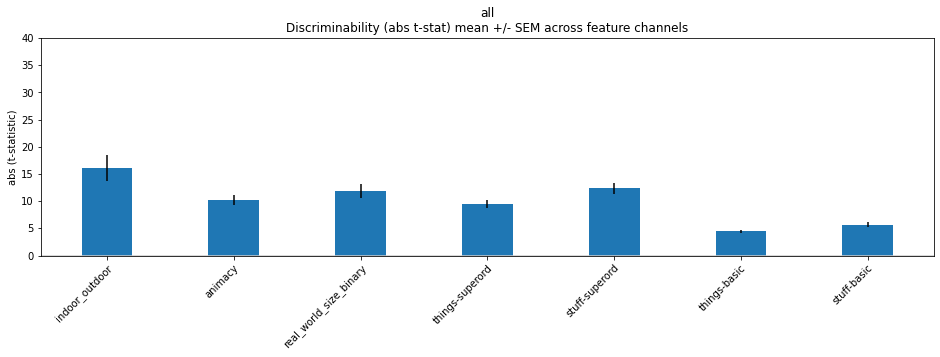

In [8]:
# Plot abs t-statistic, across all features

dd2plot = [0,2,3,5,6,7,8]
names_plot = [group_names[dd] for dd in dd2plot]
# first mean across pRFs
vals = np.mean(sem_discrim_grouped[:,:,dd2plot], axis=1)
# then mean across features
mean_vals = np.mean(vals, axis=0, keepdims=True)
sem_vals = np.std(vals, axis=0, keepdims=True)/np.sqrt(n_features)

title = '%s\nDiscriminability (abs t-stat) mean +/- SEM across feature channels'%subject

fh = plot_utils.plot_multi_bars(mean_data=mean_vals.T, err_data=sem_vals.T, \
                           colors=None, space=0.3, \
                            xticklabels=names_plot, ylabel='abs (t-statistic)', \
                            ylim=[0, 40], title=title, horizontal_line_pos=0,\
                            legend_labels=None, \
                            legend_overlaid=False, legend_separate=False, \
                            fig_size=(16,4))


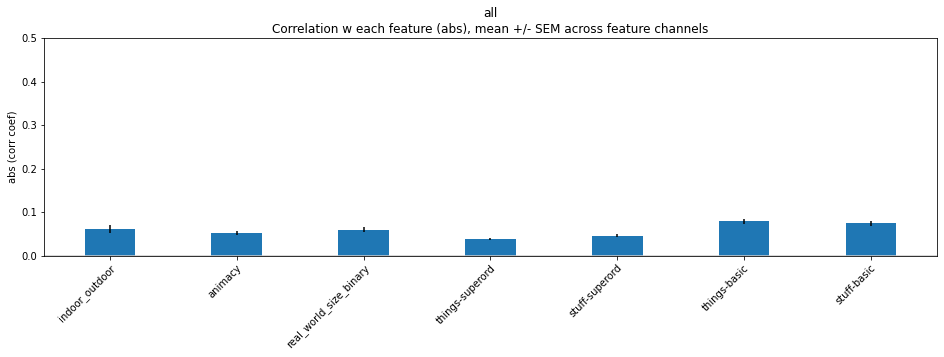

In [9]:
# Plot abs corr coef, across all features

dd2plot = [0,2,3,5,6,7,8]
names_plot = [group_names[dd] for dd in dd2plot]
# first mean across pRFs
vals = np.mean(sem_corr_grouped[:,:,dd2plot], axis=1)
# then mean across features
mean_vals = np.mean(vals, axis=0, keepdims=True)
sem_vals = np.std(vals, axis=0, keepdims=True)/np.sqrt(n_features)

title = '%s\nCorrelation w each feature (abs), mean +/- SEM across feature channels'%subject

fh = plot_utils.plot_multi_bars(mean_data=mean_vals.T, err_data=sem_vals.T, \
                           colors=None, space=0.3, \
                            xticklabels=names_plot, ylabel='abs (corr coef)', \
                            ylim=[0, 0.5], title=title, horizontal_line_pos=0,\
                            legend_labels=None, \
                            legend_overlaid=False, legend_separate=False, \
                            fig_size=(16,4))


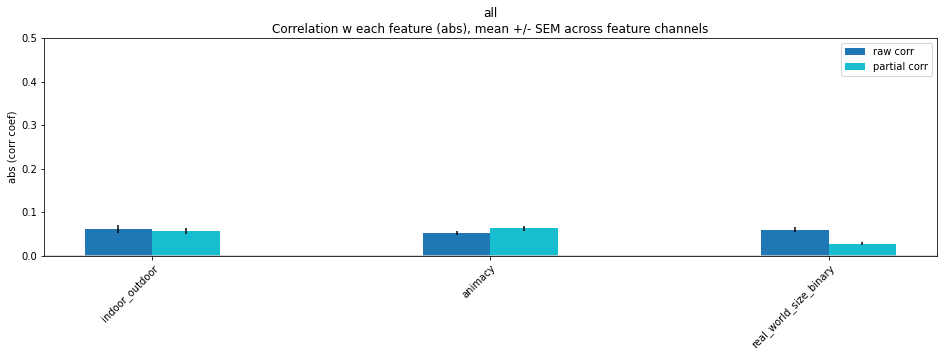

In [10]:
# Plot partial correlation coefficients for three main axes, across all features

names_plot = [names[dd] for dd in axes_to_do_partial]
# first mean across pRFs
vals = np.concatenate( [ np.mean(np.abs(corr[:,:,axes_to_do_partial]), axis=1, keepdims=True), \
                        np.mean(np.abs(partial_corr), axis=1, keepdims=True)], axis=1)
# then mean across features
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0)/np.sqrt(n_features)

title = '%s\nCorrelation w each feature (abs), mean +/- SEM across feature channels'%subject

fh = plot_utils.plot_multi_bars(mean_data=mean_vals.T, err_data=sem_vals.T, \
                           colors=None, space=0.3, \
                            xticklabels=names_plot, ylabel='abs (corr coef)', \
                            ylim=[0, 0.5], title=title, horizontal_line_pos=0,\
                            legend_labels=['raw corr','partial corr'], \
                            legend_overlaid=True, legend_separate=False, \
                            fig_size=(16,4))


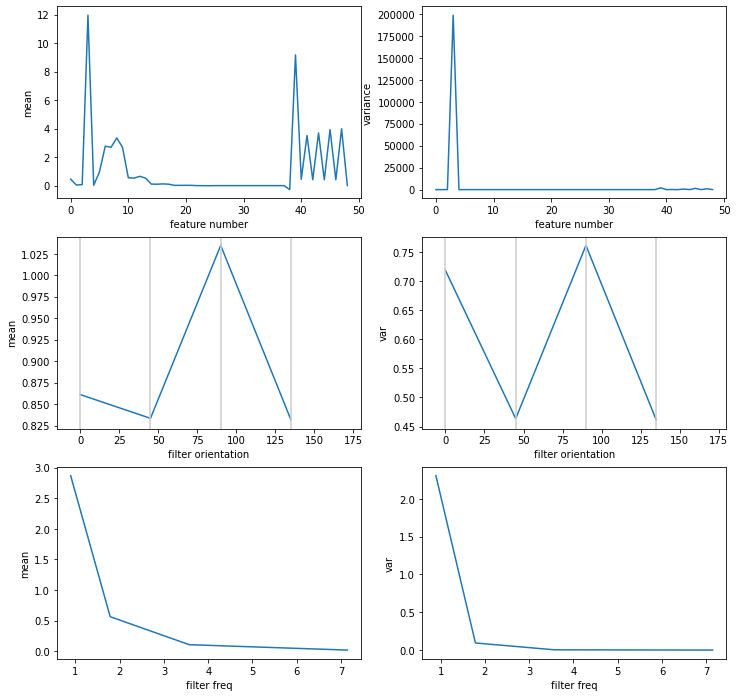

In [11]:
# Plot mean/variance each feature channel
# Averaged across pRFs

plt.figure(figsize=(12,12));

plt.subplot(3,2,1)
plt.plot(np.mean(mean, axis=1)[0:150])
plt.xlabel('feature number');
plt.ylabel('mean');
plt.subplot(3,2,2)
plt.plot(np.mean(var, axis=1)[0:150])
plt.xlabel('feature number');
plt.ylabel('variance');
     
plt.subplot(3,2,3)
plt.plot(ori_unique, np.mean(np.mean(mean_reshaped, axis=2), axis=1))
plt.xlabel('filter orientation');
plt.ylabel('mean');
plt.xlim([-15, 180])
for ii in np.arange(0,180,45):
    plt.axvline(ii, color=[0.8, 0.8, 0.8])

plt.subplot(3,2,4)
plt.plot(ori_unique, np.mean(np.mean(var_reshaped, axis=2), axis=1))
plt.xlabel('filter orientation');
plt.ylabel('var');
plt.xlim([-15, 180])
for ii in np.arange(0,180,45):
    plt.axvline(ii, color=[0.8, 0.8, 0.8])
    
plt.subplot(3,2,5)
plt.plot(sf_unique, np.mean(np.mean(mean_reshaped, axis=2), axis=0))
plt.xlabel('filter freq');
plt.ylabel('mean');

plt.subplot(3,2,6)
plt.plot(sf_unique, np.mean(np.mean(var_reshaped, axis=2), axis=0))
plt.xlabel('filter freq');
plt.ylabel('var');


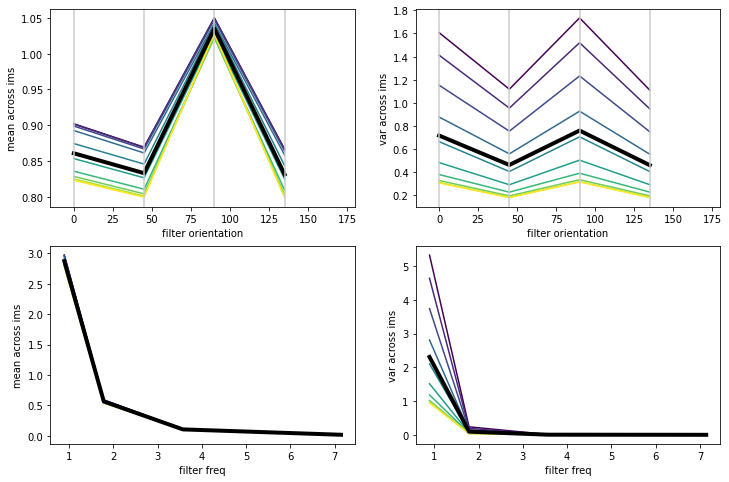

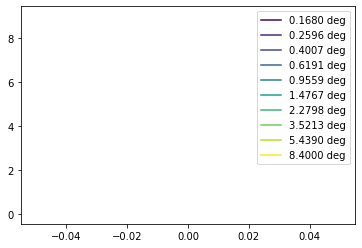

In [12]:
# Plot mean/variance of feature channels, separated by pRF properties

# Size

prf_models = initialize_fitting.get_prf_models(which_grid=5)
unique_sizes, size_inds = np.unique(np.round(prf_models[:,2],4), return_inverse=True)
colors = cm.viridis(np.linspace(0,1,len(unique_sizes)))

plt.figure(figsize=(12,8));

plt.subplot(2,2,1)
vals = np.mean(mean_reshaped, axis=1);
for ss in range(len(unique_sizes)):
    inds = size_inds==ss
    plt.plot(ori_unique, np.mean(vals[:,inds], axis=1), color=colors[ss,:])
plt.plot(ori_unique, np.mean(vals, axis=1), color='k', linewidth=4)
plt.xlabel('filter orientation');
plt.ylabel('mean across ims');
plt.xlim([-15, 180])
for ii in np.arange(0,180,45):
    plt.axvline(ii, color=[0.8, 0.8, 0.8])
    
plt.subplot(2,2,2)
vals = np.mean(var_reshaped, axis=1);
for ss in range(len(unique_sizes)):
    inds = size_inds==ss
    plt.plot(ori_unique, np.mean(vals[:,inds], axis=1), color=colors[ss,:])
plt.plot(ori_unique, np.mean(vals, axis=1), color='k', linewidth=4)
plt.xlabel('filter orientation');
plt.ylabel('var across ims');
plt.xlim([-15, 180])
for ii in np.arange(0,180,45):
    plt.axvline(ii, color=[0.8, 0.8, 0.8])

plt.subplot(2,2,3)
vals = np.mean(mean_reshaped, axis=0);
for ss in range(len(unique_sizes)):
    inds = size_inds==ss
    plt.plot(sf_unique, np.mean(vals[:,inds], axis=1), color=colors[ss,:])
plt.plot(sf_unique, np.mean(vals, axis=1), color='k', linewidth=4)
plt.xlabel('filter freq');
plt.ylabel('mean across ims');

plt.subplot(2,2,4)
vals = np.mean(var_reshaped, axis=0);
for ss in range(len(unique_sizes)):
    inds = size_inds==ss
    plt.plot(sf_unique, np.mean(vals[:,inds], axis=1), color=colors[ss,:])
plt.plot(sf_unique, np.mean(vals, axis=1), color='k', linewidth=4)
plt.xlabel('filter freq');
plt.ylabel('var across ims');

plt.figure();
for ss in range(len(unique_sizes)):
    plt.plot(0,ss,color=colors[ss,:])    
plt.legend(['%.4f deg'%(unique_sizes[ss]*8.4) for ss in range(len(unique_sizes))])

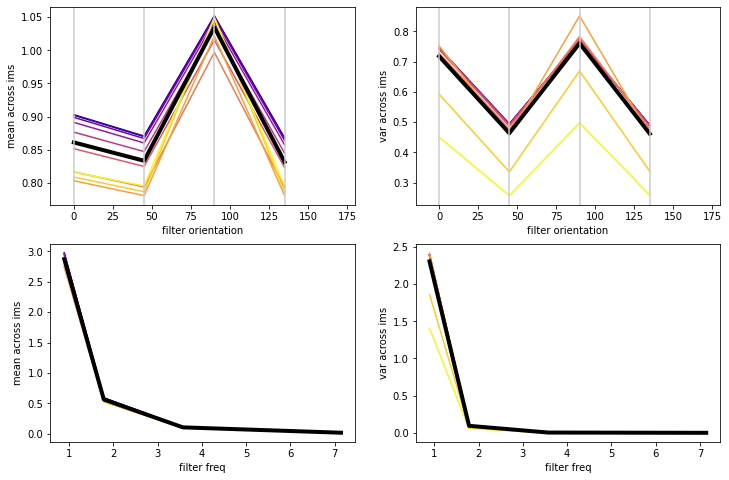

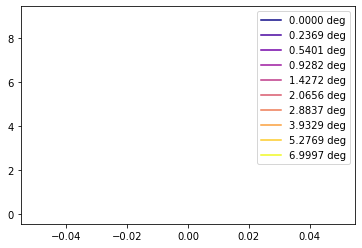

In [13]:
# Plot mean/variance of feature channels, separated by pRF properties

# Eccen

prf_models = initialize_fitting.get_prf_models(which_grid=5)
eccens = np.sqrt(prf_models[:,0]**2+prf_models[:,1]**2)
unique_eccens, eccen_inds = np.unique(np.round(eccens,4), return_inverse=True)
colors = cm.plasma(np.linspace(0,1,len(unique_eccens)))

plt.figure(figsize=(12,8));

plt.subplot(2,2,1)
vals = np.mean(mean_reshaped, axis=1);
for ee in range(len(unique_eccens)):
    inds = eccen_inds==ee
    plt.plot(ori_unique, np.mean(vals[:,inds], axis=1), color=colors[ee,:])
plt.plot(ori_unique, np.mean(vals, axis=1), color='k', linewidth=4)
plt.xlabel('filter orientation');
plt.ylabel('mean across ims');
plt.xlim([-15, 180])
for ii in np.arange(0,180,45):
    plt.axvline(ii, color=[0.8, 0.8, 0.8])
    
plt.subplot(2,2,2)
vals = np.mean(var_reshaped, axis=1);
for ee in range(len(unique_eccens)):
    inds = eccen_inds==ee
    plt.plot(ori_unique, np.mean(vals[:,inds], axis=1), color=colors[ee,:])
plt.plot(ori_unique, np.mean(vals, axis=1), color='k', linewidth=4)
plt.xlabel('filter orientation');
plt.ylabel('var across ims');
plt.xlim([-15, 180])
for ii in np.arange(0,180,45):
    plt.axvline(ii, color=[0.8, 0.8, 0.8])

plt.subplot(2,2,3)
vals = np.mean(mean_reshaped, axis=0);
for ee in range(len(unique_eccens)):
    inds = eccen_inds==ee
    plt.plot(sf_unique, np.mean(vals[:,inds], axis=1), color=colors[ee,:])
plt.plot(sf_unique, np.mean(vals, axis=1), color='k', linewidth=4)
plt.xlabel('filter freq');
plt.ylabel('mean across ims');

plt.subplot(2,2,4)
vals = np.mean(var_reshaped, axis=0);
for ee in range(len(unique_eccens)):
    inds = eccen_inds==ee
    plt.plot(sf_unique, np.mean(vals[:,inds], axis=1), color=colors[ee,:])
plt.plot(sf_unique, np.mean(vals, axis=1), color='k', linewidth=4)
plt.xlabel('filter freq');
plt.ylabel('var across ims');

plt.figure();
for ee in range(len(unique_eccens)):
    plt.plot(0,ee,color=colors[ee,:])    
plt.legend(['%.4f deg'%(unique_eccens[ee]*8.4) for ee in range(len(unique_eccens))])

Text(0.5, 0.98, 'Covariance of features, across entire image set\n(averaged over pRFs)')

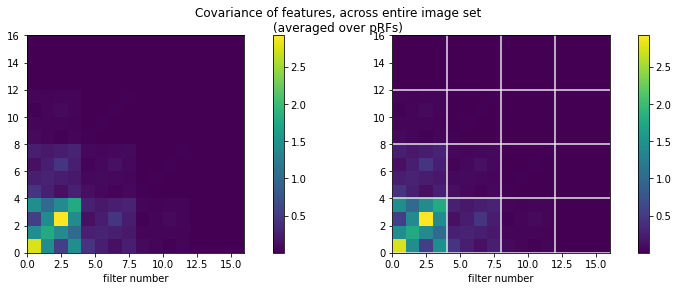

In [15]:
# Plot covariance 

plt.figure(figsize=(12,4));

plt.subplot(1,2,1)
plt.pcolormesh(np.mean(covar[feat_inds_use,:,:][:,feat_inds_use,:], axis=2))
plt.colorbar()
plt.axis('square')
plt.xlabel('filter number')
plt.xlabel('filter number')

plt.subplot(1,2,2)
plt.pcolormesh(np.mean(covar[feat_inds_use,:,:][:,feat_inds_use,:], axis=2))
plt.colorbar()
plt.axis('square')
plt.xlabel('filter number')
plt.xlabel('filter number')
for ii in range(n_sf):
    plt.axvline(ii*n_ori, color=[0.9, 0.9, 0.9])
    plt.axhline(ii*n_ori, color=[0.9, 0.9, 0.9])
    
plt.suptitle('Covariance of features, across entire image set\n(averaged over pRFs)')

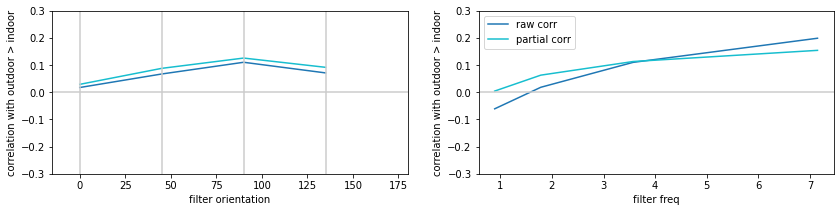

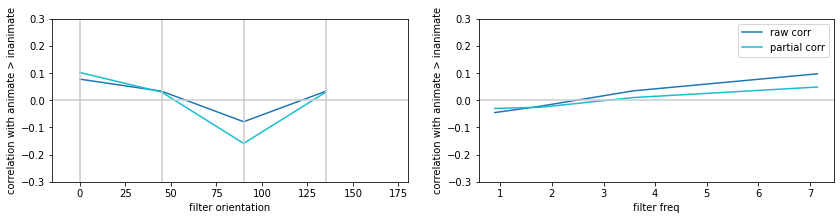

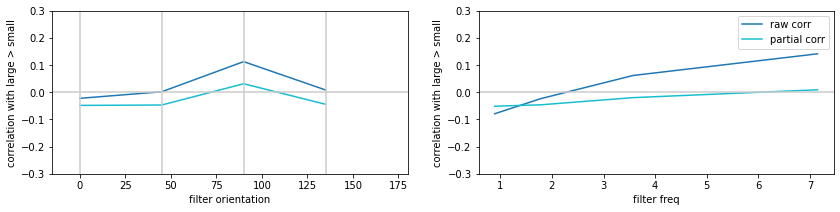

In [16]:
# Plot partial correlation of feature channels with semantic features

colors = cm.tab10(np.linspace(0, 1, 2))

for ai, aa in enumerate(axes_to_do_partial):
    
    name = partial_signed_names[ai]
    
    plt.figure(figsize=(14,3));

    plt.subplot(1,2,1)
    means1 = np.mean(corr_reshaped[:,:,:,aa], axis=1);
    means2 = np.mean(partial_corr_reshaped[:,:,:,ai], axis=1);
    plt.plot(ori_unique, np.mean(means1, axis=1), color=colors[0,:])
    plt.plot(ori_unique, np.mean(means2, axis=1), color=colors[1,:])    
    plt.xlabel('filter orientation');
    plt.ylabel('correlation with %s'%name);
    plt.xlim([-15, 180])
    plt.ylim([-0.30, 0.30])
    for ii in np.arange(0,180,45):
        plt.axvline(ii, color=[0.8, 0.8, 0.8])
    plt.axhline(0,color=[0.8, 0.8, 0.8])
    
    plt.subplot(1,2,2)
    means1 = np.mean(corr_reshaped[:,:,:,aa], axis=0);
    means2 = np.mean(partial_corr_reshaped[:,:,:,ai], axis=0);    
    plt.plot(sf_unique, np.mean(means1, axis=1), color=colors[0,:])
    plt.plot(sf_unique, np.mean(means2, axis=1), color=colors[1,:])
    plt.legend(['raw corr','partial corr'])
    plt.xlabel('filter freq');
    plt.ylabel('correlation with %s'%name);
    plt.axhline(0,color=[0.8, 0.8, 0.8])
    plt.ylim([-0.30, 0.30])
    

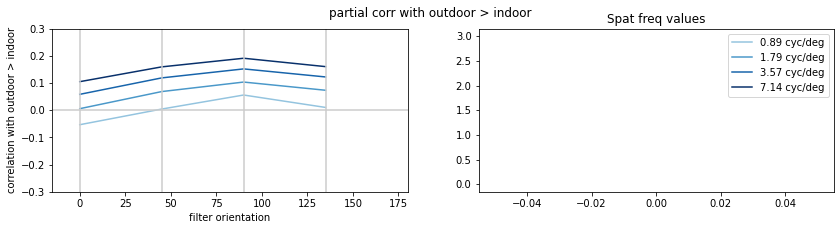

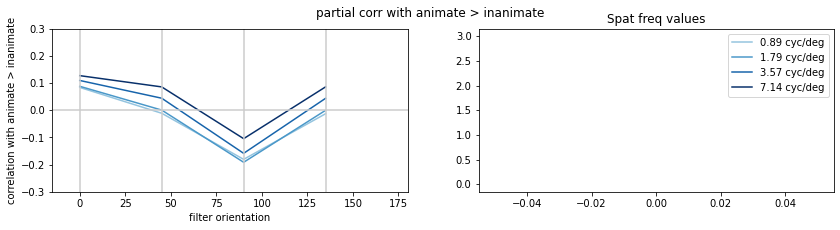

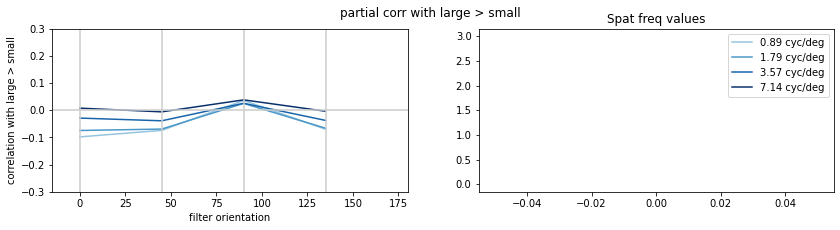

In [17]:
# Plot orientation effect for different spatial frequencies

sf_colors = cm.Blues(np.linspace(0,1,n_sf+2))[2:,:]

for ai, aa in enumerate(axes_to_do_partial):
    
    name = partial_signed_names[ai]
    
    plt.figure(figsize=(14,3));

    plt.subplot(1,2,1)
    means = np.mean(partial_corr_reshaped[:,:,:,ai], axis=2);
    for ff in range(n_sf):
        plt.plot(ori_unique, means[:,ff], color=sf_colors[ff,:])
#     plt.plot(ori_unique, np.mean(means, axis=1), color='k')    
    plt.xlabel('filter orientation');
    plt.ylabel('correlation with %s'%name);
    plt.xlim([-15, 180])
    plt.ylim([-0.30, 0.30])
    for ii in np.arange(0,180,45):
        plt.axvline(ii, color=[0.8, 0.8, 0.8])
    plt.axhline(0,color=[0.8, 0.8, 0.8])

    plt.subplot(1,2,2)
    for ff in range(n_sf):
        plt.plot(0,ff,color=sf_colors[ff,:])    
    plt.legend(['%.2f cyc/deg'%(sf_unique[ff]) for ff in range(n_sf)])
    plt.title('Spat freq values')
    
    plt.suptitle('partial corr with %s'%name)
    

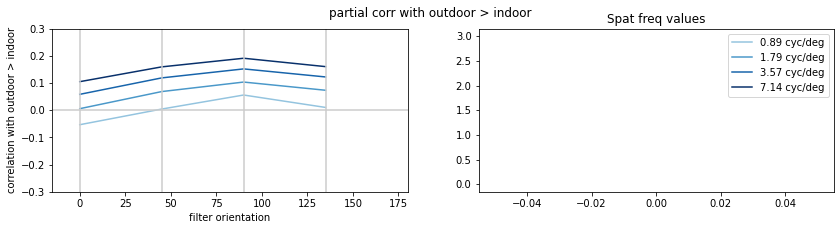

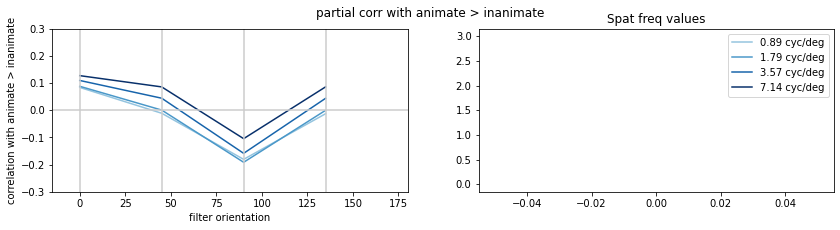

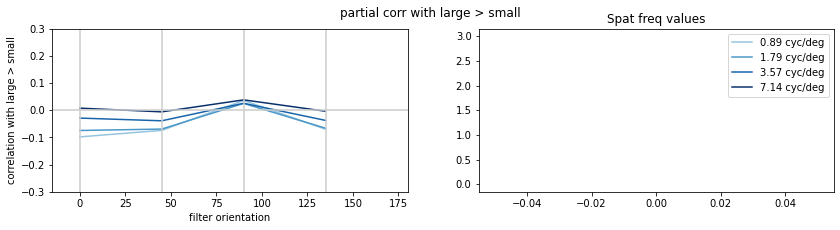

In [18]:
# Plot orientation effect for different spatial frequencies

sf_colors = cm.Blues(np.linspace(0,1,n_sf+2))[2:,:]

for ai, aa in enumerate(axes_to_do_partial):
    
    name = partial_signed_names[ai]
    
    plt.figure(figsize=(14,3));

    plt.subplot(1,2,1)
    means = np.mean(partial_corr_reshaped[:,:,:,ai], axis=2);
    for ff in range(n_sf):
        plt.plot(ori_unique, means[:,ff], color=sf_colors[ff,:])
#     plt.plot(ori_unique, np.mean(means, axis=1), color='k')    
    plt.xlabel('filter orientation');
    plt.ylabel('correlation with %s'%name);
    plt.xlim([-15, 180])
    plt.ylim([-0.30, 0.30])
    for ii in np.arange(0,180,45):
        plt.axvline(ii, color=[0.8, 0.8, 0.8])
    plt.axhline(0,color=[0.8, 0.8, 0.8])

    plt.subplot(1,2,2)
    for ff in range(n_sf):
        plt.plot(0,ff,color=sf_colors[ff,:])    
    plt.legend(['%.2f cyc/deg'%(sf_unique[ff]) for ff in range(n_sf)])
    plt.title('Spat freq values')
    
    plt.suptitle('partial corr with %s'%name)
    

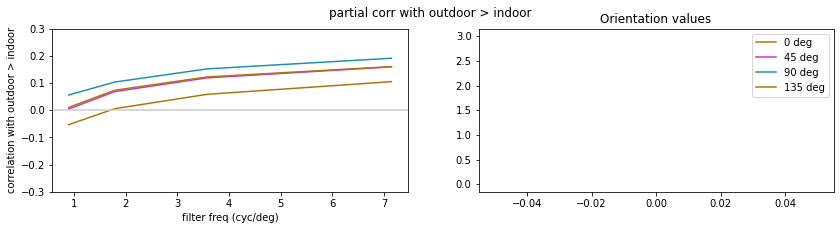

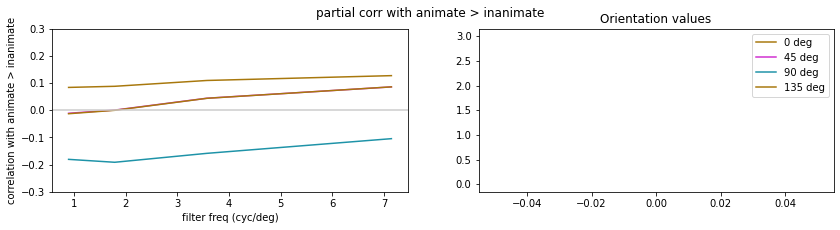

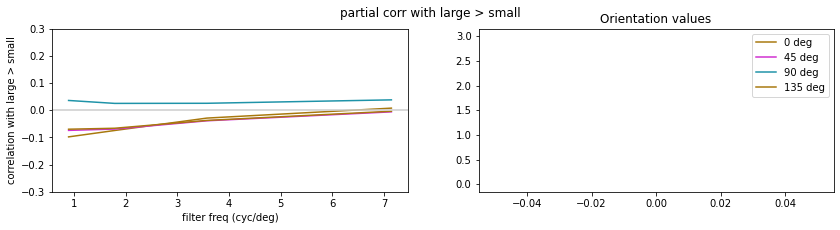

In [19]:
# Plot spat freq effect for different orientations

orient_colors = cmocean.cm.phase(np.linspace(0,1,n_ori))

for ai, aa in enumerate(axes_to_do_partial):
    
    name = partial_signed_names[ai]
    
    plt.figure(figsize=(14,3));

    plt.subplot(1,2,1)
    means = np.mean(partial_corr_reshaped[:,:,:,ai], axis=2);
    for oo in range(n_ori):
        plt.plot(sf_unique, means[oo,:], color=orient_colors[oo,:])
#     plt.plot(ori_unique, np.mean(means, axis=1), color='k')    
    plt.xlabel('filter freq (cyc/deg)');
    plt.ylabel('correlation with %s'%name);
    plt.ylim([-0.30, 0.30])
    plt.axhline(0,color=[0.8, 0.8, 0.8])

    plt.subplot(1,2,2)
    for oo in range(n_ori):
        plt.plot(0,oo,color=orient_colors[oo,:])    
    plt.legend(['%.0f deg'%(ori_unique[oo]) for oo in range(n_ori)])
    plt.title('Orientation values')
    
    plt.suptitle('partial corr with %s'%name)
    

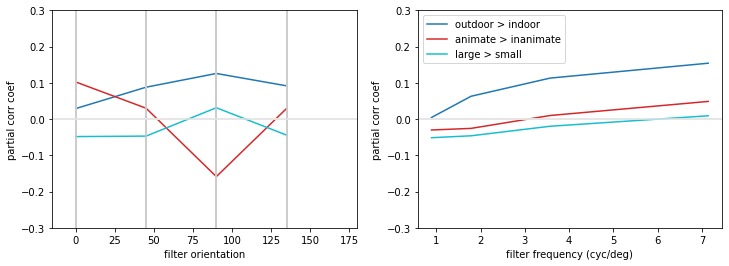

In [20]:
# Overlaying different semantic axes, partial correlations

plt.figure(figsize=(12,4));

lh = []

colors = cm.tab10(np.linspace(0,1,4))[[0,1,3],:]

for ai, aa in enumerate(axes_to_do_partial):
   
    plt.subplot(1,2,1)
    mean_each_orient = np.mean(np.mean(partial_corr_reshaped[:,:,:,ai], axis=2), axis=1);
    plt.plot(ori_unique, mean_each_orient,color=colors[ai,:])   
    plt.xlabel('filter orientation');
    plt.xlim([-15, 180])
    for ii in np.arange(0,180,45):
        plt.axvline(ii, color=[0.8, 0.8, 0.8])
    plt.axhline(0, color=[0.9, 0.9, 0.9])
    plt.ylabel('partial corr coef')
    plt.ylim([-0.30, 0.30])
    
    ax = plt.subplot(1,2,2)
    mean_each_sf = np.mean(np.mean(partial_corr_reshaped[:,:,:,ai], axis=2), axis=0);
    l, = ax.plot(sf_unique, mean_each_sf, color=colors[ai,:])
    lh.append(l)
    plt.xlabel('filter frequency (cyc/deg)');
    plt.axhline(0, color=[0.9, 0.9, 0.9]);
    plt.ylabel('partial corr coef')
    plt.ylim([-0.30, 0.30])
    
plt.legend(lh, partial_signed_names)

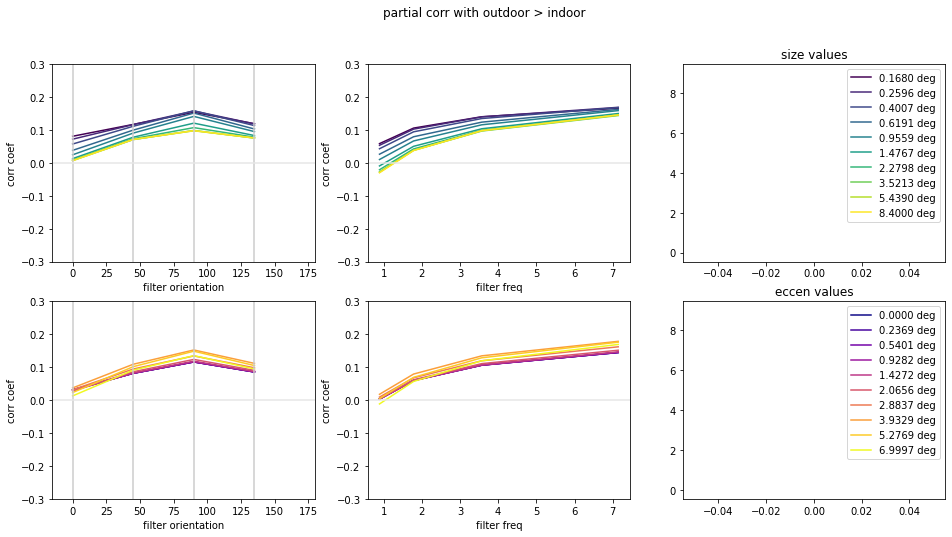

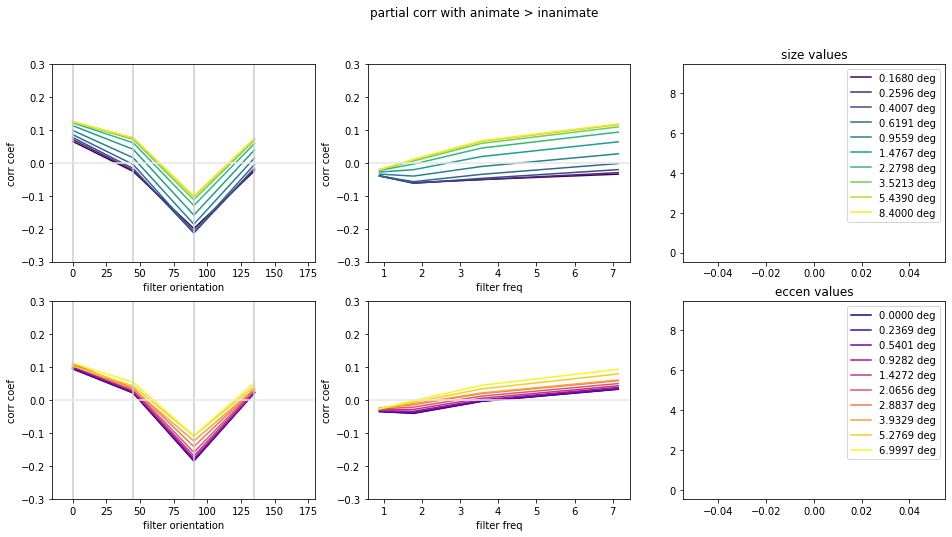

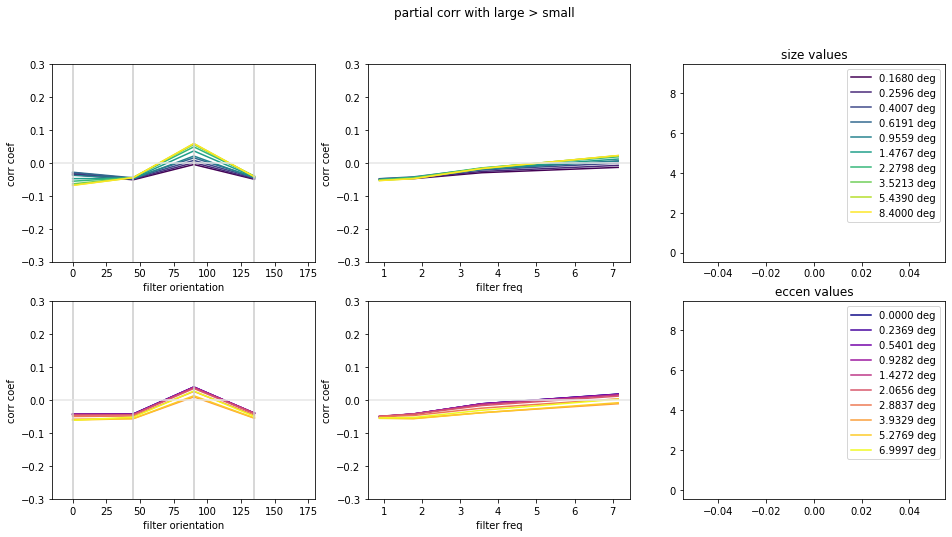

In [21]:
# Feature/semantic discriminability, separated by size/eccen of pRFs.

unique_sizes, size_inds = np.unique(np.round(prf_models[:,2],4), return_inverse=True)
size_colors = cm.viridis(np.linspace(0,1,len(unique_sizes)))

eccens = np.sqrt(prf_models[:,0]**2+prf_models[:,1]**2)
unique_eccens, eccen_inds = np.unique(np.round(eccens,4), return_inverse=True)
eccen_colors = cm.plasma(np.linspace(0,1,len(unique_eccens)))

for ai, aa in enumerate(axes_to_do_partial):
    
    name = partial_signed_names[ai]
    plt.figure(figsize=(16,8));

    plt.subplot(2,3,1)
    mean_each_orient = np.mean(partial_corr_reshaped[:,:,:,ai], axis=1);
    for ss in range(len(unique_sizes)):
        inds = size_inds==ss
        plt.plot(ori_unique, np.mean(mean_each_orient[:,inds], axis=1), color=size_colors[ss,:])
#     plt.plot(ori_unique, np.mean(mean_each_orient, axis=1), color='k', linewidth=4)
    plt.xlabel('filter orientation');
    plt.ylabel('corr coef');
    plt.xlim([-15, 180])
    plt.ylim([-0.30, 0.30])
    for ii in np.arange(0,180,45):
        plt.axvline(ii, color=[0.8, 0.8, 0.8])
    plt.axhline(0, color=[0.9, 0.9, 0.9]);

    plt.subplot(2,3,2)
    mean_each_sf = np.mean(partial_corr_reshaped[:,:,:,ai], axis=0);
    for ss in range(len(unique_sizes)):
        inds = size_inds==ss
        plt.plot(sf_unique, np.mean(mean_each_sf[:,inds], axis=1), color=size_colors[ss,:])
#     plt.plot(sf_unique, np.mean(mean_each_freq, axis=1), color='k', linewidth=4)
    plt.xlabel('filter freq');
    plt.ylabel('corr coef');
    plt.axhline(0, color=[0.9, 0.9, 0.9]);
    plt.ylim([-0.30, 0.30])
    
    plt.subplot(2,3,3);
    for ss in range(len(unique_sizes)):
        plt.plot(0,ss,color=size_colors[ss,:])    
    plt.legend(['%.4f deg'%(unique_sizes[ss]*8.4) for ss in range(len(unique_sizes))])
    plt.title('size values')
    
    plt.subplot(2,3,4)
    mean_each_orient = np.mean(partial_corr_reshaped[:,:,:,ai], axis=1);
    for ee in range(len(unique_eccens)):
        inds = eccen_inds==ee
        plt.plot(ori_unique, np.mean(mean_each_orient[:,inds], axis=1), color=eccen_colors[ee,:])
#     plt.plot(ori_unique, np.mean(mean_each_orient, axis=1), color='k', linewidth=4)
    plt.xlabel('filter orientation');
    plt.ylabel('corr coef');
    plt.xlim([-15, 180])
    plt.ylim([-0.30, 0.30])
    for ii in np.arange(0,180,45):
        plt.axvline(ii, color=[0.8, 0.8, 0.8])
    plt.axhline(0, color=[0.9, 0.9, 0.9]);

    plt.subplot(2,3,5)
    mean_each_sf = np.mean(partial_corr_reshaped[:,:,:,ai], axis=0);
    for ee in range(len(unique_eccens)):
        inds = eccen_inds==ee
        plt.plot(sf_unique, np.mean(mean_each_sf[:,inds], axis=1), color=eccen_colors[ee,:])
#     plt.plot(sf_unique, np.mean(mean_each_freq, axis=1), color='k', linewidth=4)
    plt.xlabel('filter freq');
    plt.ylabel('corr coef');
    plt.axhline(0, color=[0.9, 0.9, 0.9]);
    plt.ylim([-0.30, 0.30])
    
    plt.subplot(2,3,6);
    for ee in range(len(unique_eccens)):
        plt.plot(0,ee,color=eccen_colors[ee,:])    
    plt.legend(['%.4f deg'%(unique_eccens[ee]*8.4) for ee in range(len(unique_eccens))])
    plt.title('eccen values')
    
    plt.suptitle('partial corr with %s'%name)

In [22]:
import copy

n_axes =len(axes_to_do_partial)
n_quadrants = 4;

angle_ranges = [[ii, ii+90] for ii in np.arange(0,271,90)]

x = models[:,0]
y = models[:,1]
y_reflected = np.abs(copy.deepcopy(y))

angles = np.round(np.mod(np.arctan2(y,x)*180/np.pi, 360),1)
angles_reflected = np.round(np.mod(np.arctan2(y_reflected, x)*180/np.pi, 360),1)

ecc = np.sqrt(models[:,0]**2+models[:,1]**2)*8.4
sizes = models[:,2]*8.4
ecc_min = 2;

no_angle = ecc<10**(-2)
angles[no_angle] = np.nan
angles_reflected[no_angle] = np.nan

quadrant_names = ['upper right (ecc>%.0f deg)'%ecc_min,'upper left','lower left','lower right']

mean_info_each_quadrant = np.zeros((n_axes, n_quadrants))
std_info_each_quadrant = np.zeros((n_axes, n_quadrants))

for ai, aa in enumerate(axes_to_do_partial):
    vals = np.mean(np.abs(partial_corr[:,:,ai]), axis=0)
    for qq in range(n_quadrants):
        inds = (angles>=angle_ranges[qq][0]) & (angles<angle_ranges[qq][1]) & \
                (ecc>ecc_min)
        mean_info_each_quadrant[ai,qq] = np.mean(vals[inds])
        std_info_each_quadrant[ai,qq] = np.std(vals[inds])


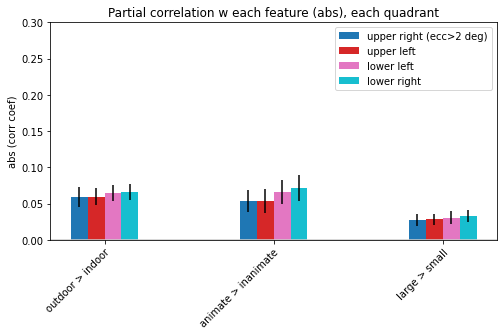

In [23]:
mean_vals = mean_info_each_quadrant
std_vals = std_info_each_quadrant

title = 'Partial correlation w each feature (abs), each quadrant'

fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=std_vals, \
                           colors=None, space=0.3, \
                            xticklabels=partial_signed_names, ylabel='abs (corr coef)', \
                            ylim=[0, 0.3], title=title, horizontal_line_pos=0,\
                            legend_labels=quadrant_names, \
                            legend_overlaid=True, legend_separate=False, \
                            fig_size=(8,4))


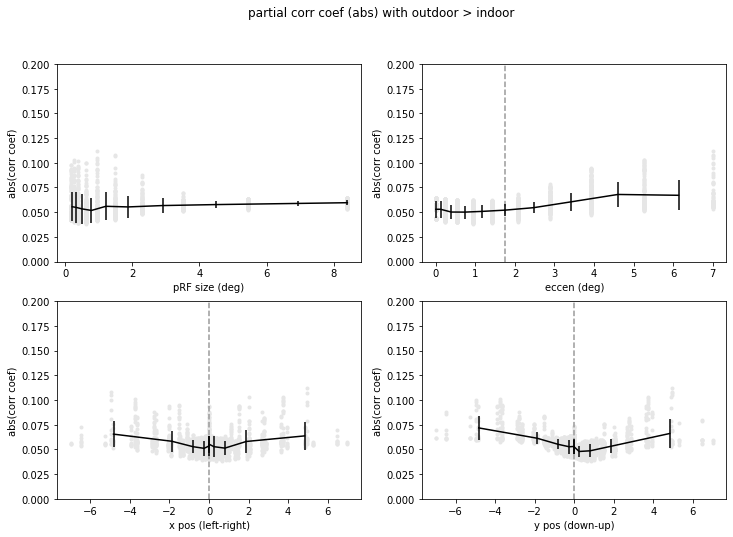

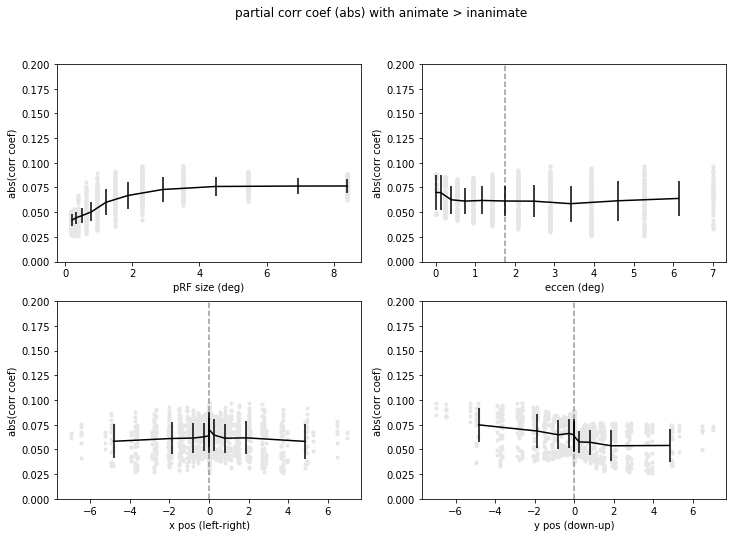

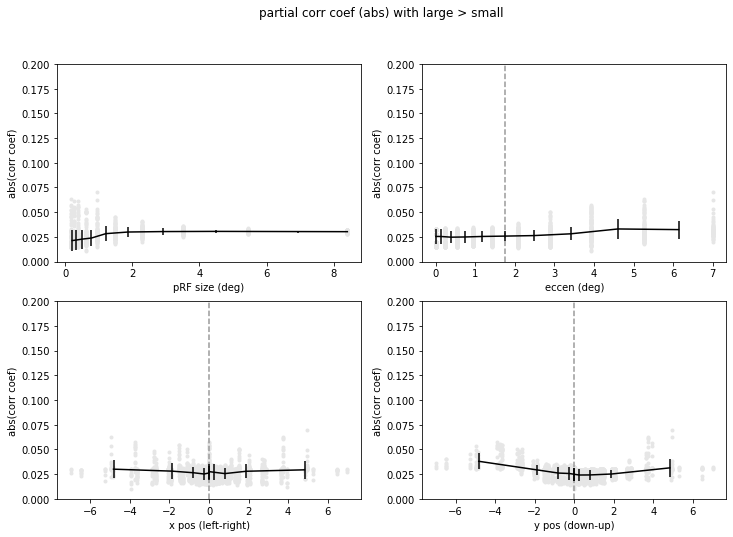

In [24]:
# plot semantic corr coefs as a function of pRF params

n_bins = 10;
linear_bins=False

ecc_vals = np.unique(np.round(ecc,2))
ecc_cutoff = ecc_vals[4]+(ecc_vals[5] - ecc_vals[4])/2

for ai, aa in enumerate(axes_to_do_partial):
    
    name = partial_signed_names[ai]
    vals = np.mean(np.abs(partial_corr[:,:,ai]), axis=0)
    
    
    plt.figure(figsize=(12,8));

    plt.subplot(2,2,1)
    x_vals = models[:,2]*8.4
    plt.plot(x_vals, vals,'.',color=[0.9, 0.9, 0.9])
    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True)    
    plt.errorbar(xbinned, ybinned, ystd, color='k',zorder=10)
    plt.xlabel('pRF size (deg)')
    plt.ylabel('abs(corr coef)')
    plt.ylim([0, 0.2])

    plt.subplot(2,2,2)
    x_vals = np.sqrt(models[:,0]**2+models[:,1]**2)*8.4
    plt.plot(x_vals, vals,'.',color=[0.9, 0.9, 0.9])
    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True)    
    plt.errorbar(xbinned, ybinned, ystd, color='k',zorder=10)
    plt.xlabel('eccen (deg)')
    plt.ylabel('abs(corr coef)')
    plt.ylim([0, 0.2])
    plt.axvline(ecc_cutoff,linestyle='--',color=[0.6, 0.6, 0.6])
    
    plt.subplot(2,2,3)
    x_vals = models[:,0]*8.4
    plt.plot(x_vals, vals,'.',color=[0.9, 0.9, 0.9])
    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True)    
    plt.errorbar(xbinned, ybinned, ystd, color='k',zorder=10)
    plt.xlabel('x pos (left-right)')
    plt.ylabel('abs(corr coef)')
    plt.ylim([0, 0.2])
    plt.axvline(0,linestyle='--',color=[0.6, 0.6, 0.6])
    
    plt.subplot(2,2,4)
    x_vals = models[:,1]*8.4
    plt.plot(x_vals, vals,'.',color=[0.9, 0.9, 0.9])
    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True)    
    plt.errorbar(xbinned, ybinned, ystd, color='k',zorder=10)
    plt.xlabel('y pos (down-up)')
    plt.ylabel('abs(corr coef)')
    plt.ylim([0, 0.2])
    plt.axvline(0,linestyle='--',color=[0.6, 0.6, 0.6])
    
    plt.suptitle('partial corr coef (abs) with %s'%name)

In [25]:
# t-test, compare upper vs lower visual field

import scipy.stats

upper_pts = np.where((angles<180) & (angles>0))[0]
lower_pts = np.where((angles>180) & (angles<360))[0]
print('n upper: %d'%upper_pts.shape[0])
print('n lower: %d'%lower_pts.shape[0])

for ai, aa in enumerate(axes_to_do_partial):
    
    vals = np.mean(np.abs(partial_corr[:,:,ai]), axis=0)
    
    vals_upper = vals[upper_pts]
    vals_lower = vals[lower_pts]

    print('%s corr, lower vs upper visual field'%partial_signed_names[ai])
    print(scipy.stats.ttest_ind(vals_lower, vals_upper))

n upper: 570
n lower: 570
outdoor > indoor corr, lower vs upper visual field
Ttest_indResult(statistic=8.759979122732638, pvalue=6.958701079456744e-18)
animate > inanimate corr, lower vs upper visual field
Ttest_indResult(statistic=14.926941652803599, pvalue=3.787043634551823e-46)
large > small corr, lower vs upper visual field
Ttest_indResult(statistic=7.651531706281307, pvalue=4.2170431123070717e-14)


In [26]:
# t-test, compare left vs right visual field

import scipy.stats

right_pts = np.where((angles<90)| (angles>270))[0]
left_pts = np.where((angles>90) & (angles<270))[0]
print('n right: %d'%right_pts.shape[0])
print('n left: %d'%left_pts.shape[0])

for ai, aa in enumerate(axes_to_do_partial):
    
    vals = np.mean(np.abs(partial_corr[:,:,ai]), axis=0)
    
    vals_left = vals[left_pts]
    vals_right = vals[right_pts]

    print('%s corr, left vs right visual field'%partial_signed_names[ai])
    print(scipy.stats.ttest_ind(vals_left, vals_right))

n right: 570
n left: 570
outdoor > indoor corr, left vs right visual field
Ttest_indResult(statistic=0.8020058975474069, pvalue=0.4227169858684321)
animate > inanimate corr, left vs right visual field
Ttest_indResult(statistic=0.07647042550437688, pvalue=0.9390582835296466)
large > small corr, left vs right visual field
Ttest_indResult(statistic=0.5517545569612224, pvalue=0.5812248526028765)


In [27]:
# t-test, compare more foveal vs more peripheral

import scipy.stats

ecc_vals = np.unique(np.round(ecc,2))
ecc_cutoff = ecc_vals[4]+(ecc_vals[5] - ecc_vals[4])/2
ecc_vals>ecc_cutoff

central_pts = np.where((ecc<ecc_cutoff))[0]
periph_pts = np.where((ecc>ecc_cutoff))[0]

print('n central: %d'%central_pts.shape[0])
print('n periph: %d'%periph_pts.shape[0])

for ai, aa in enumerate(axes_to_do_partial):
    
    vals = np.mean(np.abs(partial_corr[:,:,ai]), axis=0)
    
    vals_central = vals[central_pts]
    vals_periph = vals[periph_pts]

    print('%s corr, central vs peripheral visual field'%partial_signed_names[ai])
    print(scipy.stats.ttest_ind(vals_central, vals_periph))

n central: 800
n periph: 656
outdoor > indoor corr, central vs peripheral visual field
Ttest_indResult(statistic=-21.344365408578774, pvalue=3.7411366973127797e-88)
animate > inanimate corr, central vs peripheral visual field
Ttest_indResult(statistic=2.512168634485491, pvalue=0.012106739427620646)
large > small corr, central vs peripheral visual field
Ttest_indResult(statistic=-11.774282014314974, pvalue=1.2407741717720087e-30)


In [28]:
# t-test, compare left vs right visual field

import scipy.stats

right_pts = np.where((angles<90)| (angles>270))[0]
left_pts = np.where((angles>90) & (angles<270))[0]
print('n right: %d'%right_pts.shape[0])
print('n left: %d'%left_pts.shape[0])

for ai, aa in enumerate(axes_to_do_partial):
    
    vals = np.mean(np.abs(partial_corr[:,:,ai]), axis=0)
    
    vals_left = vals[left_pts]
    vals_right = vals[right_pts]

    print('%s corr, left vs right visual field'%partial_signed_names[ai])
    print(scipy.stats.ttest_ind(vals_left, vals_right))

n right: 570
n left: 570
outdoor > indoor corr, left vs right visual field
Ttest_indResult(statistic=0.8020058975474069, pvalue=0.4227169858684321)
animate > inanimate corr, left vs right visual field
Ttest_indResult(statistic=0.07647042550437688, pvalue=0.9390582835296466)
large > small corr, left vs right visual field
Ttest_indResult(statistic=0.5517545569612224, pvalue=0.5812248526028765)
